In [51]:
from topo import *

from scipy import signal
from giotto.time_series import Resampler, TakensEmbedding
from giotto.homology import VietorisRipsPersistence
from giotto.diagrams import Filtering, PairwiseDistance, BettiCurve, PersistenceLandscape, Amplitude, HeatKernel
from giotto.diagrams._utils import _subdiagrams
from giotto.pipeline import Pipeline
from sklearn.manifold import smacof
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score, f1_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
x = pd.read_csv('training_un7FCmp.csv')
y = pd.read_csv('target_ATndViR.csv')
xtest = pd.read_csv('input_test_YW07KeM.csv')
y_label = y[['TARGET']].rename(columns={'TARGET': 'label'})


In [75]:
%%time
bcs, x_vrpd = topo_pipeline(x, bigm=1, rel_std=16, scale=10, period=5, time_delay=1, dimension=5, 
              homology_dimensions=None, max_edge_length=20, n_values_bc=2000, kde=False, ints=True)

Creating gaussian spikes
Resampling
Creating Takens Embedding
Creating V-R Persistence Diagrams
Creating Betti curves
CPU times: user 32.9 s, sys: 2.57 s, total: 35.5 s
Wall time: 47.6 s


In [76]:
topo_features = gen_topo_features(bcs, x_vrpd, sum_range_0=120, sum_range_1=60)

bc_area
tropical
amplitudes
moments
scaler


In [67]:
# Join with tsfresh features
tsfresh_features = pd.read_pickle("tsfresh_features.pkl")
topo_features = topo_features.join(tsfresh_features)


In [77]:
# Under-sampling
tf_us = topo_features.join(y_label).groupby('label').head(3000)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(tf_us.drop(columns=['label']), tf_us.label.values, test_size=0.2, random_state=42)

In [79]:
rf = RandomForestClassifier(n_estimators=100) #, class_weight={0: 4.439, 1: 1}
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
print('\nRandomForestClassifier')
print(confusion_matrix(y_test, preds))
print(cohen_kappa_score(y_test, preds))
print(f1_score(y_test, preds))


RandomForestClassifier
[[389 234]
 [228 349]]
0.22916278513607835
0.6017241379310345


In [80]:
preds = rf.predict(topo_features) # .join(tsfresh_features)
ytemp = topo_features.join(y_label).label.values
print(confusion_matrix(ytemp, preds))
print(cohen_kappa_score(ytemp, preds))
print(f1_score(ytemp, preds))

[[9477 4100]
 [ 250 2808]]
0.41423724476906076
0.563515954244431


In [81]:
%%time
model = RandomForestClassifier(random_state=0)

param_dist = {'max_depth': [5, 10, 20, 50, None],
              'n_estimators': [10, 100, 1000]}

scoring = make_scorer(cohen_kappa_score)

gs = GridSearchCV(model, param_grid=param_dist, scoring=scoring, verbose=5, n_jobs=-1, return_train_score=True, cv=5)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.1min finished


CPU times: user 1.35 s, sys: 131 ms, total: 1.48 s
Wall time: 1min 7s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max

In [82]:
gs.best_score_

0.32614260402764683

In [74]:
preds = gs.best_estimator_.predict(topo_features)
ytemp = topo_features.join(y_label).label.values
print(confusion_matrix(ytemp, preds))
print(cohen_kappa_score(ytemp, preds))
print(f1_score(ytemp, preds))

[[9899 3678]
 [ 382 2676]]
0.4262212019761926
0.5686357841053974


In [63]:
pd.DataFrame({'name': X_train.columns.values, 'fi': gs.best_estimator_.feature_importances_}).sort_values(by='fi', ascending=False)

,name,fi
2,"x__change_quantiles__f_agg_""var""__isabs_False_...",0.030083
0,"x__change_quantiles__f_agg_""var""__isabs_True__...",0.026911
17,x__quantile__q_0.1,0.024464
6,"x__change_quantiles__f_agg_""mean""__isabs_True_...",0.020870
1,"x__change_quantiles__f_agg_""var""__isabs_True__...",0.020254
...,...,...
82,x__large_standard_deviation__r_0.25,0.000312
68,x__symmetry_looking__r_0.05,0.000279
60,x__ratio_beyond_r_sigma__r_6,0.000097
72,x__large_standard_deviation__r_0.1500000000000...,0.000065


In [ ]:
log_clf = LogisticRegression(solver="liblinear")
log_clf.fit(X_train, y_train)
preds = log_clf.predict(X_test)
print('\nLogisticRegression')
print(confusion_matrix(y_test, preds))
print(cohen_kappa_score(y_test, preds))

sgd_clf = SGDClassifier(n_jobs=-1, max_iter=2000)
sgd_clf.fit(X_train, y_train)
preds = sgd_clf.predict(X_test)
print('\nSGDClassifier')
print(confusion_matrix(y_test, preds))
print(cohen_kappa_score(y_test, preds))

svc = LinearSVC(max_iter=5000)
# svc.fit(X_train, y_train)
# preds = svc.predict(X_test)
# print('\nLinearSVC')
# print(confusion_matrix(y_test, preds))
# print(cohen_kappa_score(y_test, preds))

mlp = MLPClassifier(max_iter=300)
mlp.fit(X_train, y_train)
preds = mlp.predict(X_test)
print('\nMLPClassifier')
print(confusion_matrix(y_test, preds))
print(cohen_kappa_score(y_test, preds))

rf = RandomForestClassifier(n_estimators=100) #, class_weight={0: 4.439, 1: 1}
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
print('\nRandomForestClassifier')
print(confusion_matrix(y_test, preds))
print(cohen_kappa_score(y_test, preds))
print(f1_score(y_test, preds))

gnb = GaussianNB()
gnb.fit(X_train, y_train)
preds = gnb.predict(X_test)
print('\nGNB')
print(confusion_matrix(y_test, preds))
print(cohen_kappa_score(y_test, preds))

kn = KNeighborsClassifier(3)
kn.fit(X_train, y_train)
preds = kn.predict(X_test)
print('\nKNN')
print(confusion_matrix(y_test, preds))
print(cohen_kappa_score(y_test, preds))

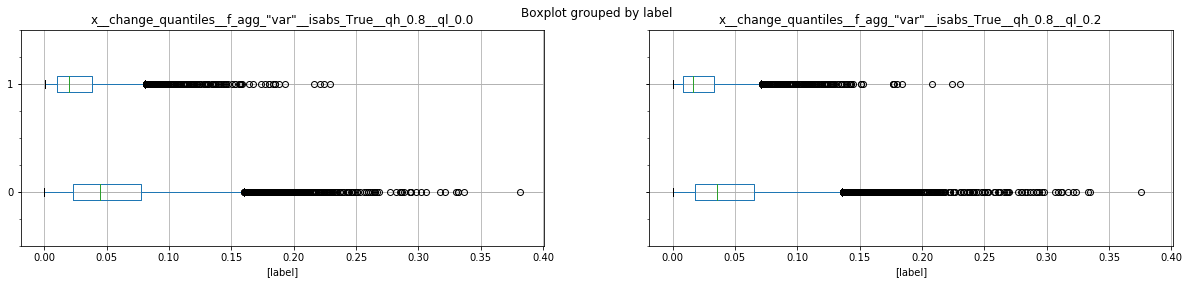

In [88]:
tsfresh_features.iloc[:, :2].join(y_label).boxplot(by='label', vert=False, figsize=(20, 4))
plt.show()

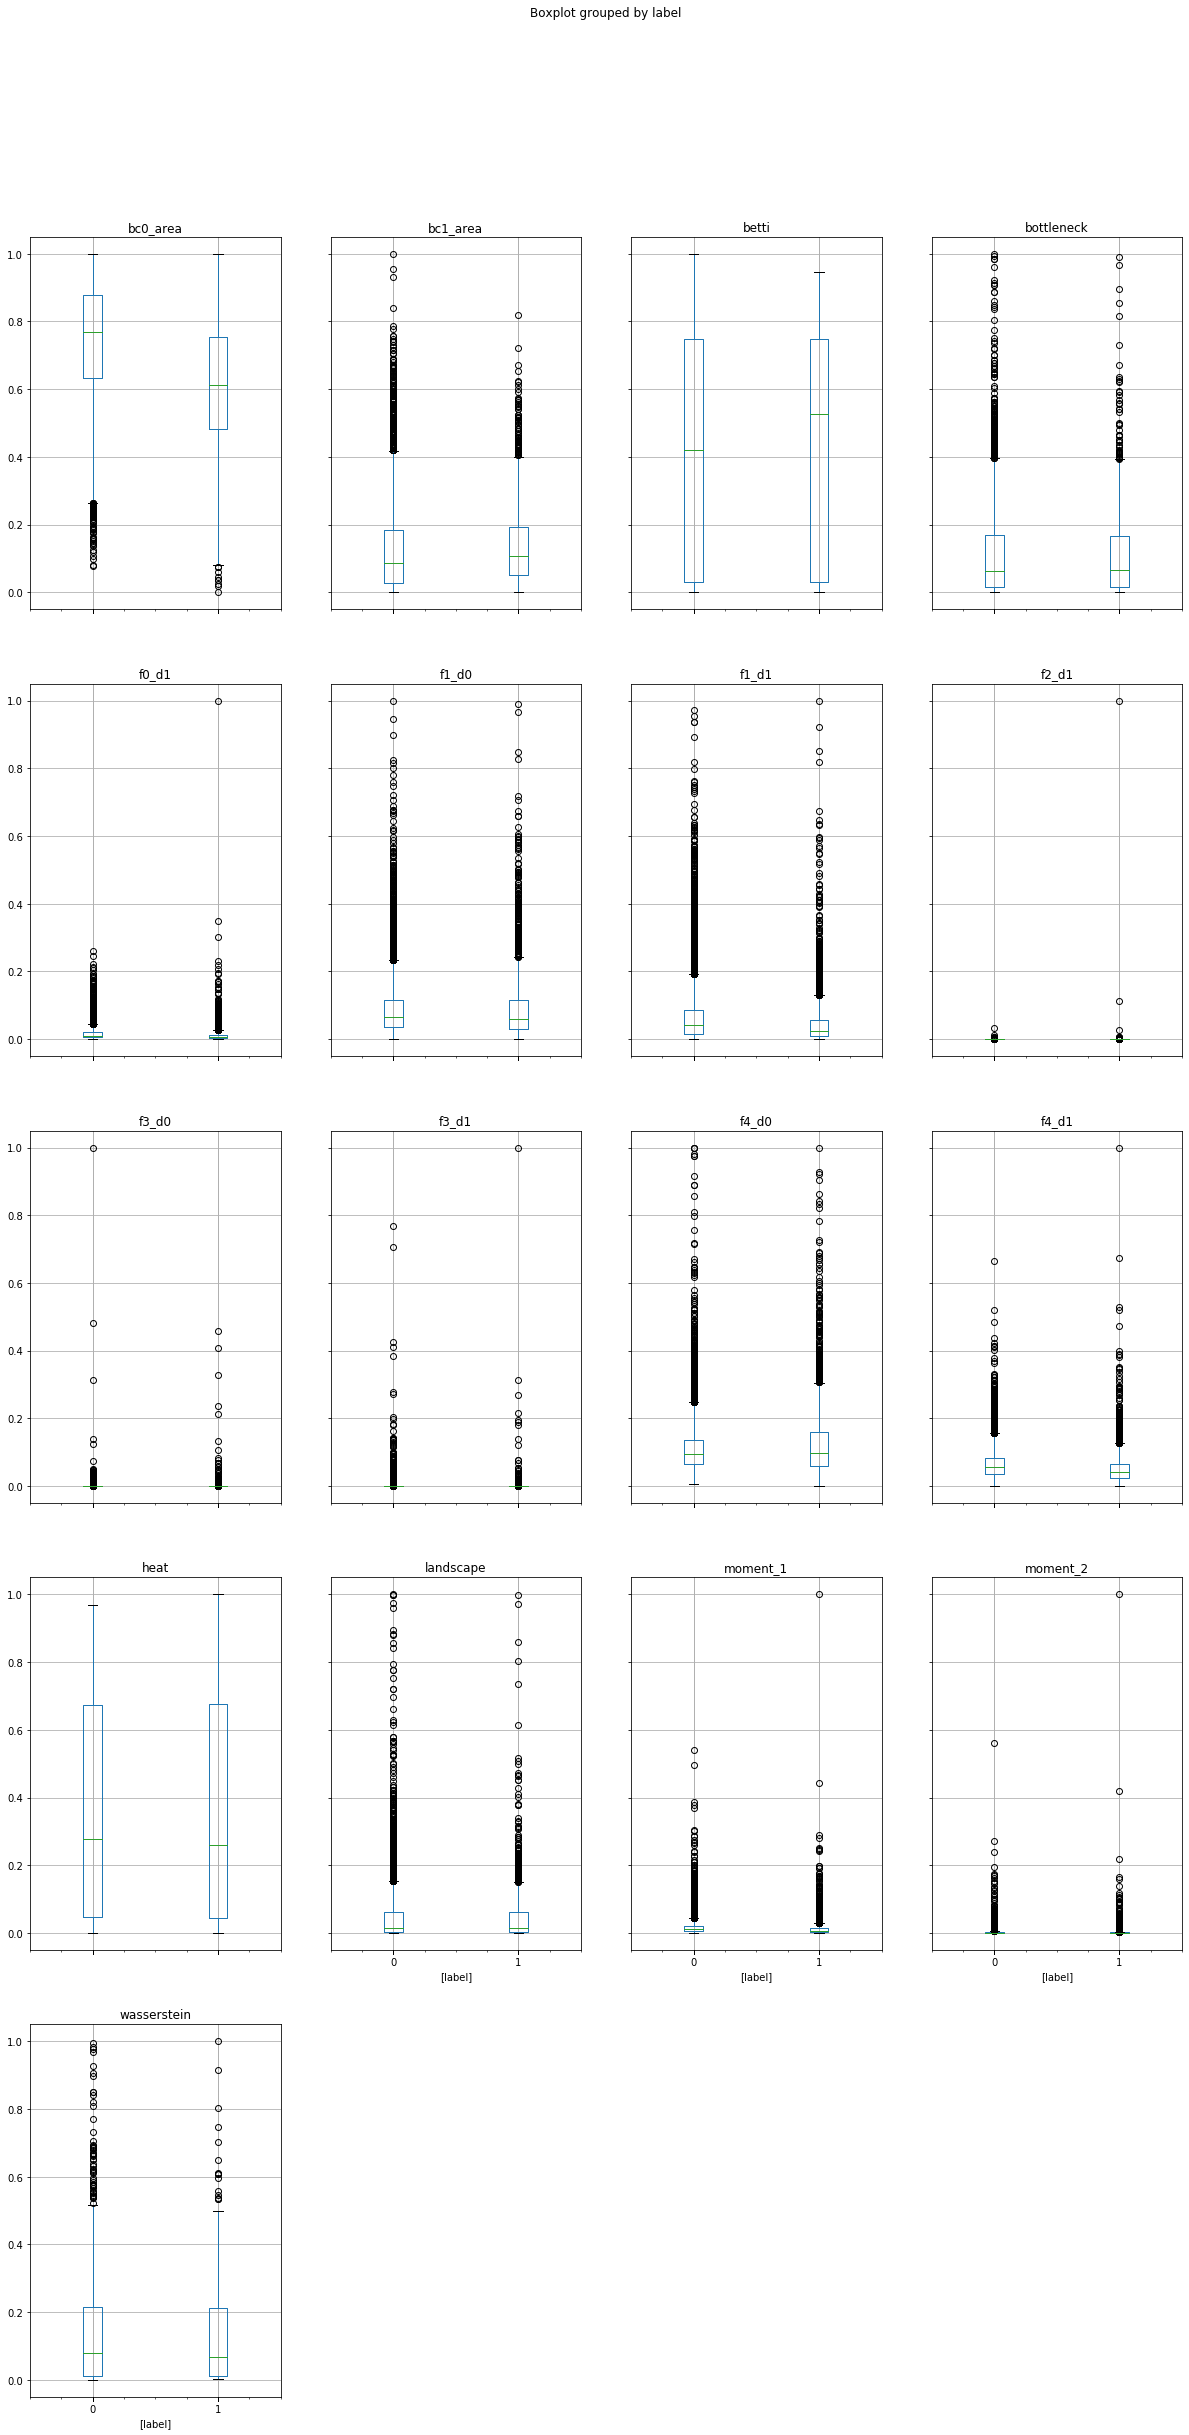

In [93]:
topo_features.join(y_label).boxplot(by='label', figsize=(20, 40))
plt.show()